In [1]:
import random
import time
import pandas as pd
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

### Arms and synthetic reward generator

In [2]:
class GaussianArm():
    """
    An arm with a gaussian distribution (bounded)
    """
    def __init__(self, mean, stdev, minv, maxv):
        """
        @param mean: mean of the distribution
        @param stdev: standard deviation of the distribution
        @param minv: minimum possible value
        @param maxv: maximum possible value
        """
        self.mean = mean
        self.stdev = stdev
        self.minv = minv
        self.maxv = maxv

    def pull(self):
        """
        Pull the arm and get a reward
        @return the reward
        """
        reward = min(self.maxv, max(self.minv, round(normal(loc=self.mean, scale=self.stdev),2)))
        return reward
    
    def pull_list(self, T):
        """
        Pull the arm T times
        @return the list of rewards
        """
        rewards = normal(loc=self.mean, scale=self.stdev, size=T)
        rewards = [min(self.maxv, max(self.minv, round(r,2))) for r in rewards]
        return rewards

class SyntheticDataGenerator:
    """
    A utility class to generate synthetic data from arms
    """
    
    def __init__(self, arms_params):
        """
        @param params: list of tuples (mean, stdev, minv, maxv) representing parmeters
                       of the arms' distributions of rewards
        """
        self.K = len(arms_params)
        self.arms_params = []
    
    def generate(self, T):
        """
        Generate T samples
        @return a list of (arm_id, reward) pairs
        """
        sequence = []
        for arm_idx in range(0,self.K):
            arm = GaussianArm(*arms_params[arm_idx])
            data = arm.pull_list(T//K)
            data = [ (arm_idx, min(maxv, max(minv, round(d,2)))) for d in data]
            sequence += data
        random.shuffle(sequence)
        return sequence

### Multi-Armed Bandits strategies

In [3]:
class EpsilonGreedy:
    """
    Epsilon greedy MAB
    """
    def __init__(self, epsilon, K):
        """
        @param epsilon : the epsilon-greedy exploration parameter
        @param K: number of arms
        """
        if epsilon < 0 or epsilon > 1:
            raise Exception ('Epsilon should be in [0,1]')
        self.epsilon = epsilon
        self.K = K
        self.avg_rewards = np.zeros(self.K)  # average reward for each arm
        self.tot_rewards = np.zeros(self.K)  # total reward for each arm
        self.times_pulled = np.zeros(self.K)  # number of times each arm was pulled
        
    def get_tot_reward(self):
        """
        @return the total reward accumulated
        """
        return sum(self.tot_rewards)
    
    def get_number_pulls(self):
        """
        @return the total number of times an arm has been pulled
        """
        return sum(self.times_pulled)
    
    def __str__(self):
        s = f'=== MAB state ===\n'
        s += f'Epsilon Greedy: epsilon={self.epsilon}, arms={self.K}\n'
        s += f'Trained with {self.get_number_pulls()} actions; Total reward = {self.get_tot_reward()}\n'
        s += f'Avg. reward = {self.avg_rewards}\n'
        s += f'# pulls = {self.times_pulled}\n'
        s += '================='
        return s
        
    def select_arm(self):
        """
        Select the best arm according to the strategy
        @return arm: the index of the selected arm
        @return explore: binary value encoding whether the MAB decided to explore
        """
        p = np.random.rand()
        if p > self.epsilon:
            best_arm_idx = np.argmax(self.avg_rewards)
            return (best_arm_idx, 0)
        else:
            return (np.random.choice(range(0,self.K)), 1)

    def update(self, arm, reward):
        """
        Update the model parameters
        @param arm: arm 
        @param reward : binary value
        """
        self.times_pulled[arm] += 1
        self.tot_rewards[arm] += reward
        self.avg_rewards[arm] = self.tot_rewards[arm] / self.times_pulled[arm]
        
    def reset(self):
        """
        Reset the state of MAB
        """
        self.avg_rewards = np.zeros(self.K)
        self.tot_rewards = np.zeros(self.K)
        self.times_pulled = np.zeros(self.K)
        self.pull_history = []
        
    def run_simulation(self, arms, T, verbose=False):
        """
        Runs a simulation on the given arms for T timesteps
        @param arms: List of Arms objects
        @param T: length of the simulation
        """
        simulation_cum_rewards = []
        simulation_tot_rewards = 0
        pull_history = []
        if len(arms) != K:
            raise Exception(f'number of arms shuould be K={self.K}')
        for t in range(0, T):
            arm, has_explored = self.select_arm()
            reward = arms[arm].pull()
            simulation_tot_rewards += reward
            simulation_cum_rewards.append(simulation_tot_rewards)
            pull_history.append(arm)
            self.update(arm, reward)
            if verbose:
                print(f'ROUND {t} ---')
                print(f'arm={arm}, has_explored={has_explored}, reward={reward}')
                print(f'avg_rewards = {self.avg_rewards}')
        return (simulation_cum_rewards, pull_history)
        
    def run_replay(self, data, verbose=False):
        """
        Runs a Replay offline evaluation with the given data
        @param data: a list of (arm,reward) pairs
        @param verbose: for a verbose representation of the replay
        """
        replay_num_matches = 0
        replay_tot_rewards = 0
        replay_cum_rewards = []
        pull_history = []
        for i, action in enumerate(data):
            mab_arm, has_explored = self.select_arm()
            actual_arm, reward = action
            if mab_arm == actual_arm: #change the state of the MAB only if there is a match
                if verbose:
                    print(f'ROUND {replay_num_matches} ({i}) ---')
                    print(f'arm={actual_arm}, mab_arm={mab_arm}, match={mab_arm == actual_arm}, has_explored={has_explored}, reward={reward}')
                    print(f'avg_rewards = {self.avg_rewards}')
                replay_num_matches += 1
                replay_tot_rewards += reward
                replay_cum_rewards.append(replay_tot_rewards)
                pull_history.append(mab_arm)
                mab.update(mab_arm, reward)
        return (replay_cum_rewards, pull_history)
    
    
def visualize_simulation(cum_rewards, pull_history, savefile=None):
    """
    Utility function to draw a visual representation of the simulation
    @param cum_rewards: list of cumulative rewards in time
    @param pull_history: list of arm indices pulled over time
    """
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    ax1, ax2=axs
    ax1.plot(range(0,len(cum_rewards)), cum_rewards)
    ax1.set_ylabel('Cumulative reward', fontsize=18)
    ax1.set_xlabel('Rounds', fontsize=18)
    ax2.scatter(range(0,len(pull_history)), pull_history, s=4, alpha=0.8)
    ax2.set_ylabel('Arms', fontsize=18)
    ax2.set_xlabel('Rounds', fontsize=18)
    ax1.tick_params(labelsize=18)
    ax2.tick_params(labelsize=18)
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=400)

number of pulls: [4, 7, 30, 3, 61]
average_rewards: [12.08, 25.12, 125.34999999999998, 6.35, 267.1700000000001]
[4, 7, 30, 3, 61]
cum_rewards: [4.54, 9.23, 13.65, 18.65, 21.869999999999997, 26.869999999999997, 31.72, 36.72, 41.01, 46.01, 51.01, 56.01, 59.82, 62.95, 67.44, 71.95, 75.99000000000001, 80.99000000000001, 85.99000000000001, 89.88000000000001, 93.49000000000001, 97.15, 101.72, 106.67999999999999, 111.67999999999999, 116.67999999999999, 120.85, 125.39999999999999, 129.92, 134.54, 137.82, 142.82, 147.82, 152.82, 157.82, 161.87, 165.1, 169.98, 173.42999999999998, 176.73, 180.22, 184.25, 187.89, 192.89, 195.19, 198.79, 202.79, 205.98999999999998, 209.29999999999998, 214.05999999999997, 217.67999999999998, 219.93999999999997, 223.78999999999996, 228.78999999999996, 232.85999999999996, 237.85999999999996, 241.95999999999995, 246.95999999999995, 251.95999999999995, 256.72999999999996, 261.7, 265.06, 269.41, 274.13000000000005, 278.15000000000003, 283.15000000000003, 286.18, 290.41, 

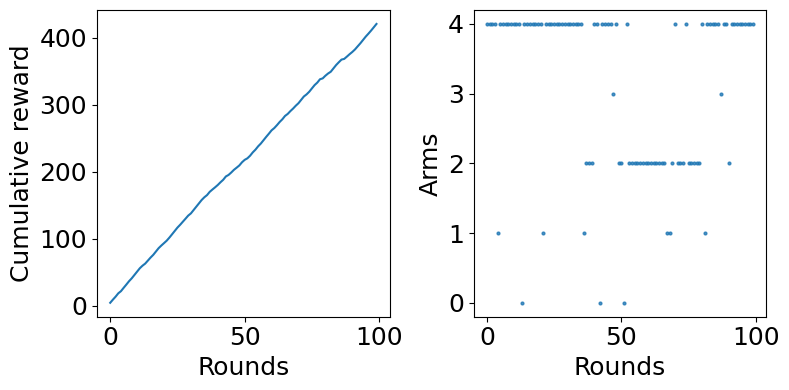

In [69]:
import math
############################################
### Exercise: implement the UCB strategy ###
############################################
# test_arm = GaussianArm(3, 1, 0, 1)
# test_arm.pull()




def u_cum_b_1(T: int, arms: list[GaussianArm]):
    arms_len = len(arms)
    rewards = [a.pull() for a in arms]
    number_of_pulls = [1 for i in range(arms_len)]
    max_arms = [0 for i in range(arms_len)]
    cum_rewards = [0 for i in range(T)]
    pull_history = [0 for i in range(T)]

    def calc_reward(t, ai):
        m_t = t + 1
        return (rewards[ai] / number_of_pulls[ai]) + math.sqrt((2 * math.log(m_t)) / (number_of_pulls[ai]))
    
    for t in range(T):
        for ai in range(arms_len):
            max_arms[ai] = calc_reward(t, ai)
        
        max_idx = max_arms.index(max(max_arms))
        reward = arms[max_idx].pull()
        rewards[max_idx] += reward
        number_of_pulls[max_idx] += 1 
        cum_rewards[t]+= (0 if t == 0 else cum_rewards[t - 1] ) + reward
        pull_history[t] = max_idx

    print(f"number of pulls: {number_of_pulls}")
    print(f"average_rewards: {rewards}")
    print(number_of_pulls)
    return cum_rewards, pull_history

        
minv=1 #minimum value of reward
maxv=5 #maximum value of reward
arms = [GaussianArm(3, 1, minv, maxv), 
        GaussianArm(3.5, 1, minv, maxv), 
        GaussianArm(4.5, 1, minv, maxv), 
        GaussianArm(1.8, 1, minv, maxv),
        GaussianArm(4.5, 0.8, minv, maxv)]

T = 100
cum_rewards, pull_history = u_cum_b_1(T, arms)
print(f"cum_rewards: {cum_rewards}")
print(f"pull_history: {pull_history}")


visualize_simulation(cum_rewards, pull_history, 'fig.png')


### Simulation

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 150.0 actions; Total reward = 610.8299999999999
Avg. reward = [2.68375    3.54833333 4.31842105 1.925      4.35095238]
# pulls = [ 16.   6.  19.   4. 105.]


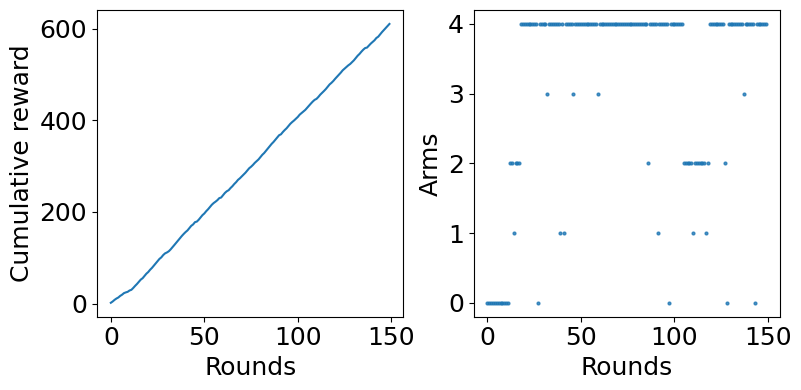

In [5]:
#create example arms
minv=1 #minimum value of reward
maxv=5 #maximum value of reward
arms = [GaussianArm(3, 1, minv, maxv), 
        GaussianArm(3.5, 1, minv, maxv), 
        GaussianArm(4.5, 1, minv, maxv), 
        GaussianArm(1.8, 1, minv, maxv),
        GaussianArm(4.5, 0.8, minv, maxv)] 

#instantiate MAB
K = len(arms)
alpha = 0.1
mab = EpsilonGreedy(alpha, K)

#run simulation on given arms
T = 150
cum_rewards, pull_history = mab.run_simulation(arms, T, verbose=False)
print(mab)

visualize_simulation(cum_rewards, pull_history, 'fig.png')

### Replay evaluation

=== MAB state ===
Epsilon Greedy: epsilon=0.1, arms=5
Trained with 204.0 actions; Total reward = 846.6
Avg. reward = [2.76428571 3.81       4.23125    1.93       3.985     ]
# pulls = [  7.   6. 184.   1.   6.]


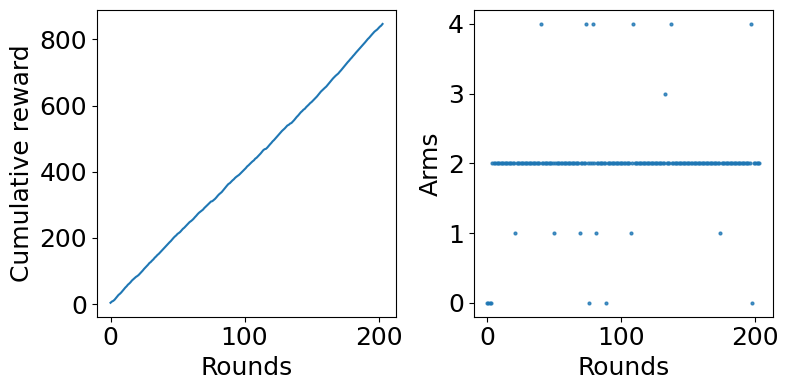

In [6]:
# generate data
minv=1 #minimum value of reward
maxv=5 #maximum value of reward
arms_params = [(3, 1, minv, maxv),
               (3.5, 1, minv, maxv), 
               (4.5, 1, minv, maxv), 
               (1.8, 1, minv, maxv), 
               (4.5, 0.8, minv, maxv)]
K = len(arms_params)
N = 1000
generator = SyntheticDataGenerator(arms_params)
data = generator.generate(N) #generate N datapoints from the arms

#instantiate MAB
alpha = 0.1
mab = EpsilonGreedy(alpha, K)

#run Replay on given data
cum_rewards, pull_history = mab.run_replay(data, verbose=False)
print(mab)

visualize_simulation(cum_rewards, pull_history)